In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy import signal
from scipy.io import wavfile
import numpy as np
from IPython.display import Audio, clear_output
from scipy.signal import fftconvolve
from scipy.fftpack import fft, ifft

Generisanje audio signala

In [2]:
F1 = 200
F2 = 400
F3 = 500
F4 = 700
Fs = 11025
t0 = 0.3
t = np.arange(0,t0,1./Fs)
x1 = np.sin(2 * np.pi * F1 * t )
x2 = np.sin(2 * np.pi * F2 * t )
x3 = np.sin(2 * np.pi * F3 * t )
x4 = np.sin(2 * np.pi * F4 * t )

x = x1+x2+x3+x4
x = x / np.max(np.abs(x))
#dopunjen nulama do 3 sekunde
input_signal = np.zeros(11025*3)
input_signal[:x.size] = x

wavfile.write("input_signal.wav", Fs, x.astype(np.float16)) 

Audio(input_signal,rate = Fs)

Ucitavanje audio signala

In [3]:
input_audio_file = "acoustic.wav"
Fs, input = wavfile.read(input_audio_file)
input = input / np.max(np.abs(input))
Audio(input,rate=Fs)

Funkcija za upis u header

In [4]:
def create_c_header(input_signal, filename, sample_rate):
    # Otvaranje datoteke za upis
    with open(filename, 'w') as header_file:
        header_file.write('#ifndef AUDIO_DATA_H_\n')
        header_file.write('#define AUDIO_DATA_H_\n\n')

        # Definisanje frekvencije odmjeravanja
        header_file.write(f'#define SAMPLE_RATE {sample_rate}\n\n')

        # Definisanje duzine niza
        header_file.write(f'#define AUDIO_DATA_LENGTH {len(input_signal)}\n\n')

        # Upis niza podataka ulaznog signala
        header_file.write('float audio_data[] = {\n    ')
        for i, sample in enumerate(input_signal):
            header_file.write(f'{sample:.8f}, ')
            if (i + 1) % 10 == 0:  # nakon svakih 10 uzoraka nova linija
                header_file.write('\n    ')  
            
        header_file.write('\n};\n')

        header_file.write('#endif // AUDIO_DATA_H_\n')


In [5]:
filename = "audio_data.h"
create_c_header(input, filename, sample_rate=Fs)

In [6]:
filename = "test_signal.h"
create_c_header(input_signal, filename, sample_rate=Fs)

Funkcije za iscrtavanje signala

In [7]:
def plotSignals(input_signal,output_signal):
    figure(num=None,figsize=(18,4))
    #t = np.arange( len(input_signal)) / Fs
    plt.plot(input_signal,label="Originalni signal",color="blue")
    plt.plot(output_signal,label="Signal sa efektom",color="orange")
    plt.legend()
    plt.show()

Funkcija za prikaza greske signala

In [8]:
def signal_error(audio_py, audio_C):
    error  = np.abs(audio_py-audio_C)
    plt.figure()
    plt.plot(error)
    plt.title("Signal greske")
    plt.show()

Funkcija za citanje binarnog fajla iz C-a

In [9]:
def read_from_C(filename):
    #otvaranje binarne datoteke za citanje
    with open(filename,'rb') as file:
        audio_data = file.read()  #audio odmjerci u bajtovima
    #konverzija bajtova y NumPy niz
    audio_samples = np.frombuffer(audio_data,dtype=np.float32)
    
    return audio_samples

Delay efekat na osnovu dijagrama prikazanog na slici:

![](basic_delay_unit.png)

Implementacija pomocu kruznog bafera

In [10]:
def delay(input_signal, Fs, delay_ms,gain):
    """
    Primjena delay efekta na ulazni signal.

    Ulazni parametri:
    input_signal    - Ulazni audio signal
    Fs              - frekvencija odmjeravanja u Hz
    delay_ms        -  kasnjenje u milisekundama
    gain            - faktor pojacanja koji je primijenjen na zakasnjeni signal 

    returns:
    Zakasnjeni izlazni signal
    """
    delay_samples = int(Fs*(delay_ms/1000.0))  # kasnjenje u odmjercima
    length = len(input_signal)
    output_signal = np.zeros(length, dtype=np.float32)
    delay_buffer = np.zeros(delay_samples, dtype=np.float32)
    
    read_index, write_index = 0, 0

    for i in range(length):
        if i < delay_samples:
            output_signal[i] = input_signal[i]
        else:
            in_sample = input_signal[i]

            delayed_sample = delay_buffer[read_index]

            out_sample = in_sample + (delayed_sample * gain)

            output_signal[i] = out_sample

            delay_buffer[write_index] = in_sample + (delayed_sample * gain)

            read_index = (read_index + 1) % delay_samples
            write_index = (write_index + 1) % delay_samples

  
    output_signal = output_signal / np.max(np.abs(output_signal))

    return output_signal

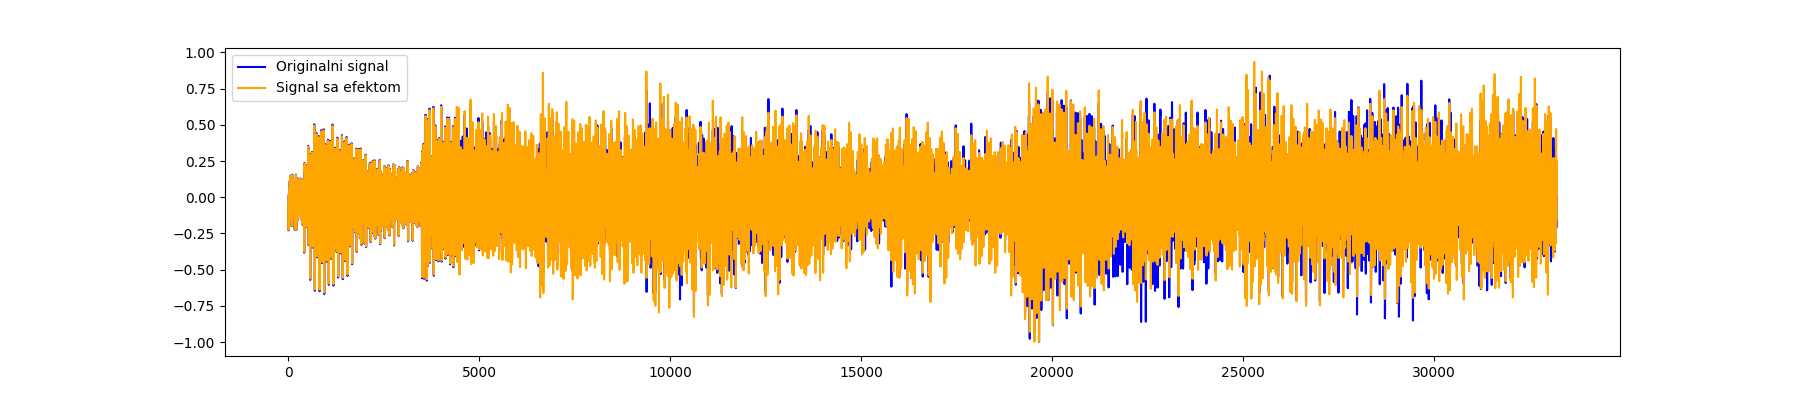

In [11]:
output_delay_buff = delay(input,Fs,200, 0.5)
plotSignals(input,output_delay_buff)
Audio(output_delay_buff,rate=Fs)

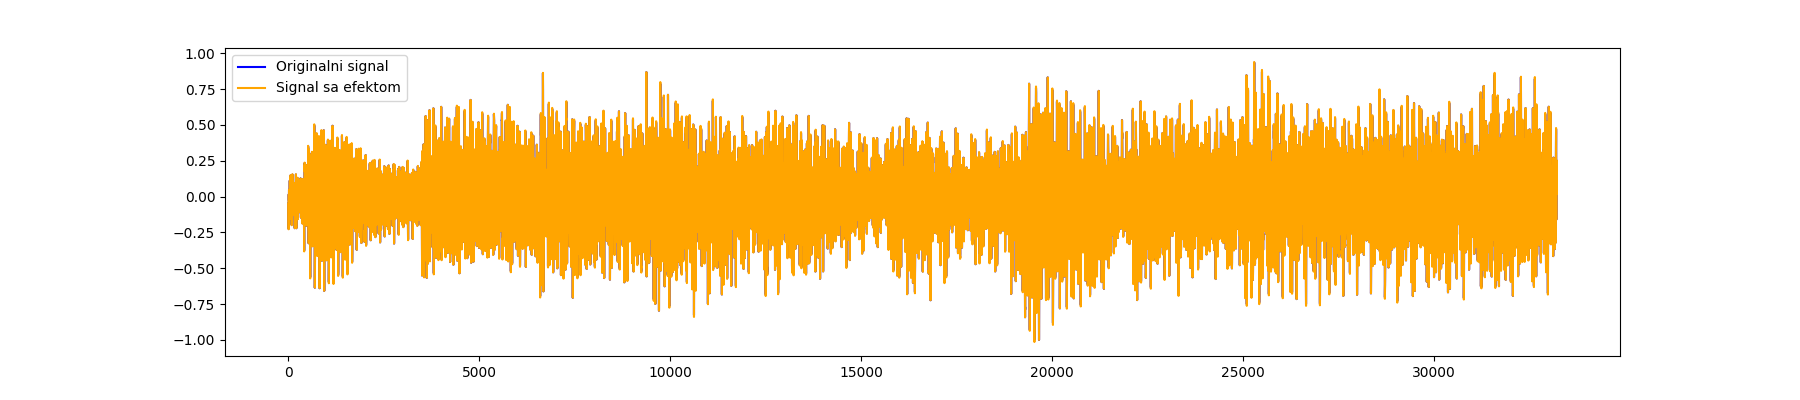

In [12]:
delay_from_C = read_from_C("output_delay_c.bin")
plotSignals(output_delay_buff,delay_from_C)
Audio(delay_from_C,rate=Fs)

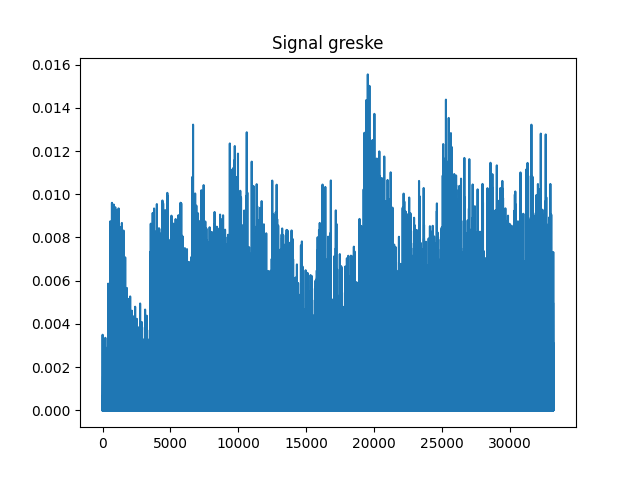

In [13]:
signal_error(output_delay_buff,delay_from_C)

Delay sa feedback petljom implementiran na principu dijagrama prikazanog ispod:

![](basic_delay_unit_with_feedback.png)

In [14]:
def delay_with_feedback(input_signal, Fs,delay_ms, feedback_gain, feedforward_gain):
    """
    Funkcija kreira eho efekat(delay with feedback) nad ulaznim audio signalom. 

    Ulazni parametri:
    input_signal    - Ulazni signal(niz odmjeraka)
    Fs              - Frekvencija odmjeravanja u Hz
    delay_ms        - Kasnjenje u milisekundama
    feedback_gain   - Pojacanje zakasnjenog signala u povratnoj petlji
    feedforward_gain- Pojacanje zakasnjenog signala koji se sabira sa ulaznim
    
    return:
    Izlazni signal nad kojim je primijenjen echo efekat
    """
    delay_samples = int(Fs* (delay_ms/1000.0))
    
    output_signal = np.zeros_like(input_signal)

    buffer = np.zeros(delay_samples)
    for n in range(len(input_signal)):
    
        input_sample = input_signal[n]

        delayed_sample = buffer[n % delay_samples]

        if n < delay_samples:
            output_signal[n] = input_sample
        else:
            
            buffer[n % delay_samples] = input_sample + feedback_gain * delayed_sample

            output_signal[n] = input_sample + feedforward_gain * delayed_sample

    output_signal = output_signal / np.max(np.abs(output_signal))

    return output_signal



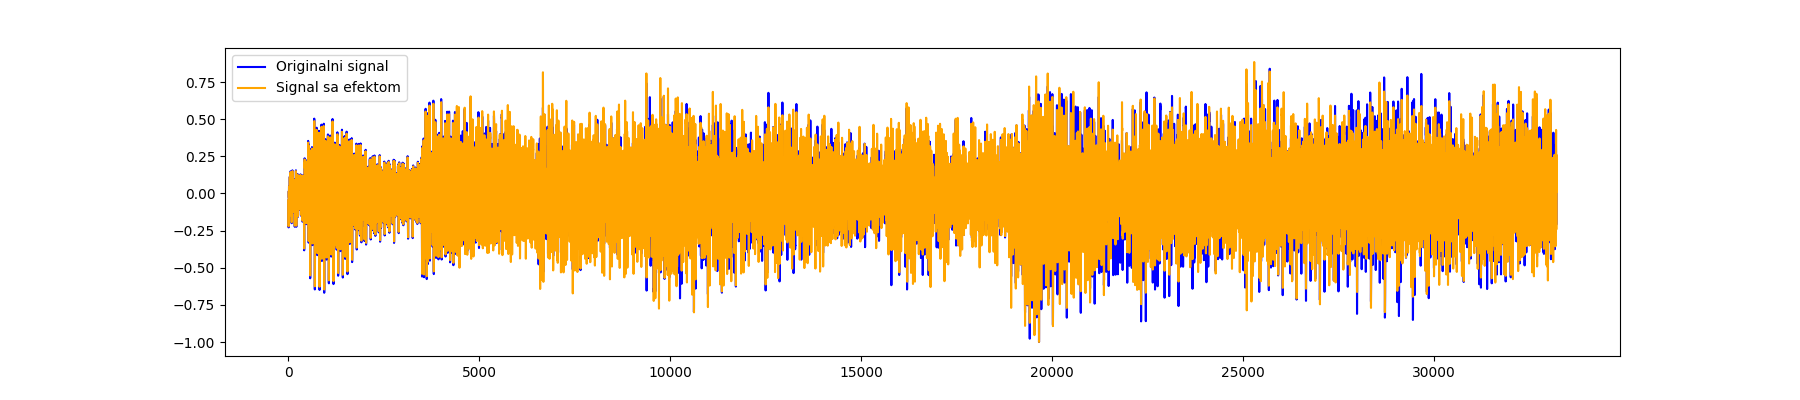

In [15]:
echo1 = delay_with_feedback(input, Fs, 200.0, 0.8, 0.4)
plotSignals(input,echo1)
Audio(echo1,rate=Fs)

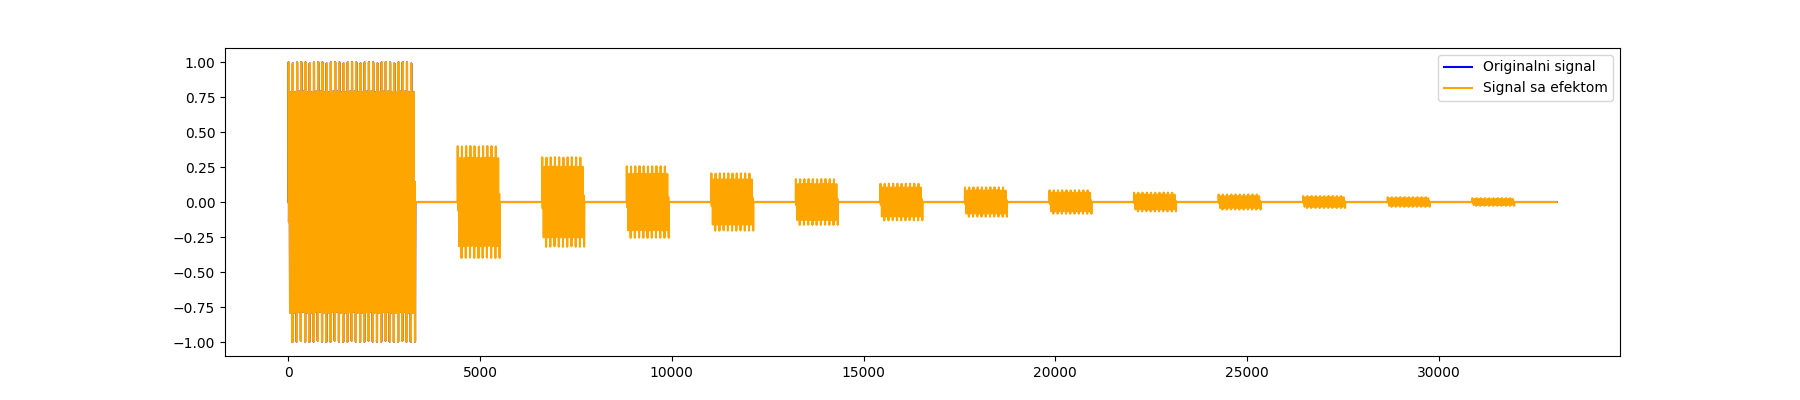

In [16]:
echo2 = delay_with_feedback(input_signal, Fs, 200.0, 0.8, 0.4)
#echo2 = echo2 / np.max(np.abs(echo2))
plotSignals(input_signal,echo2)
Audio(echo2,rate=Fs)

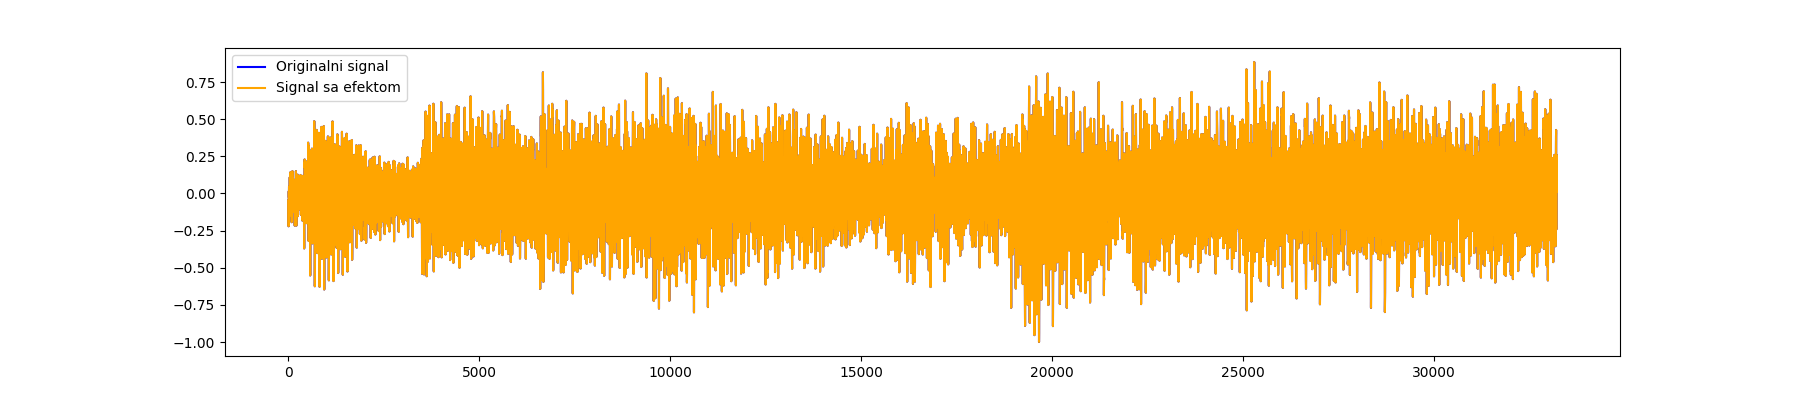

In [17]:
echo_from_C = read_from_C("output_delay_feedback_c.bin")
#echo_from_C = echo_from_C/np.max(np.abs(echo_from_C))
plotSignals(echo1,echo_from_C)
Audio(echo_from_C,rate=Fs)

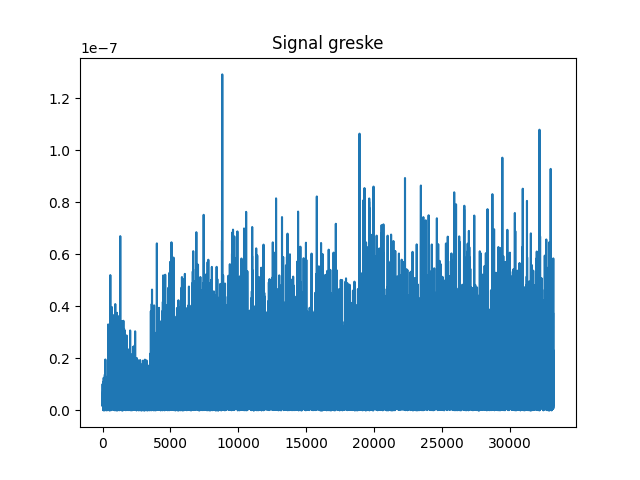

In [18]:
signal_error(echo1,echo_from_C)

Tremolo

![](tremolo.png)

In [19]:
def tremolo(input_signal,Fs,Flfo,alpha):
        """
        Ulazni parametri:
        input_signal    -   ulazni audio signal
        Fs              -   frekvencija oscilovanja u Hz
        Flfo            -  frekvencija modulacije (<20Hz)
        alpha (float)   -   faktor dubine modulacije, ukazuje koliiko ce amplitudna modulacija uticati na amplitudu originalnog signala,izmedju 0 i 1
        
        :returns:          -   izlazni audio signal nad kojim je primijenjen efekat
        
        """
        y = np.zeros(len(input_signal))
        for i in range(len(input_signal)):
            m = (1+alpha*np.sin(2*np.pi*i*(Flfo/Fs)))
            y[i] = m * input_signal[i]
        
        y = y/np.max(np.abs(y)) 
        return y


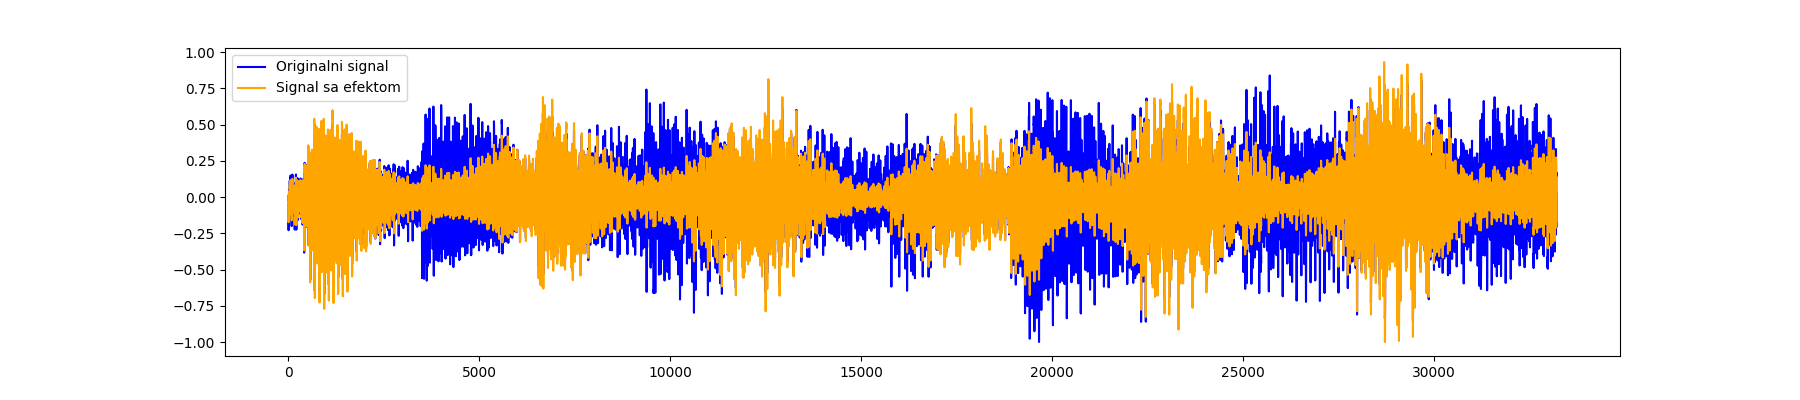

In [20]:
tremolo_output =tremolo(input,Fs,2,0.6)
plotSignals(input,tremolo_output)
Audio(tremolo_output,rate=Fs)

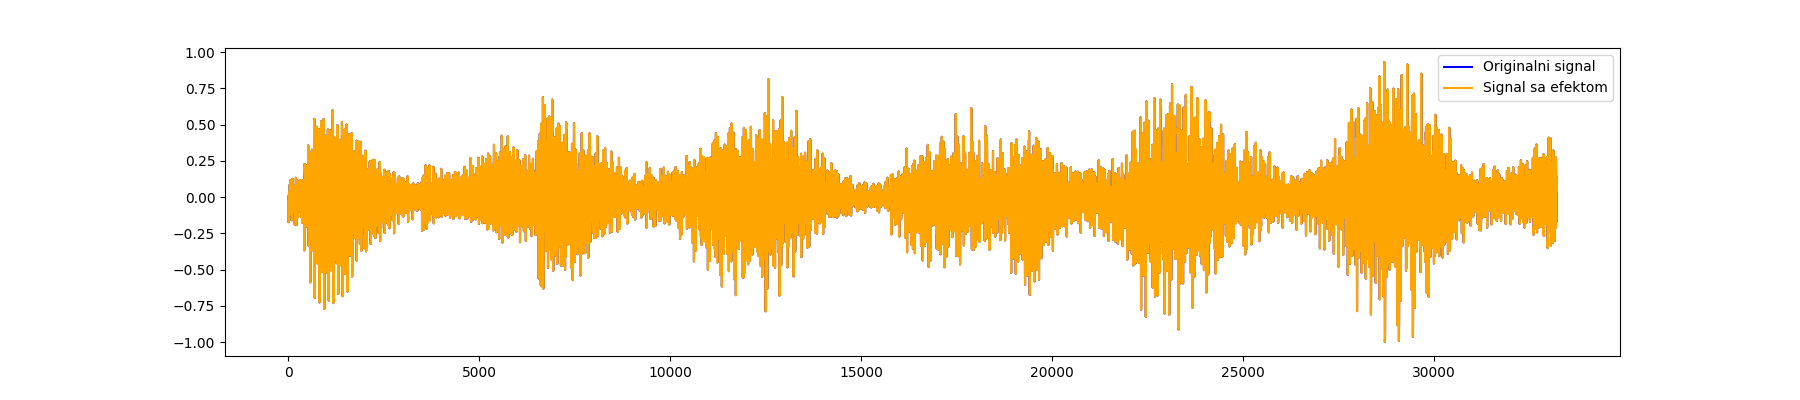

In [21]:
tremolo_from_C = read_from_C("output_tremolo_C.bin")
plotSignals(tremolo_output,tremolo_from_C)
Audio(tremolo_from_C,rate=Fs)

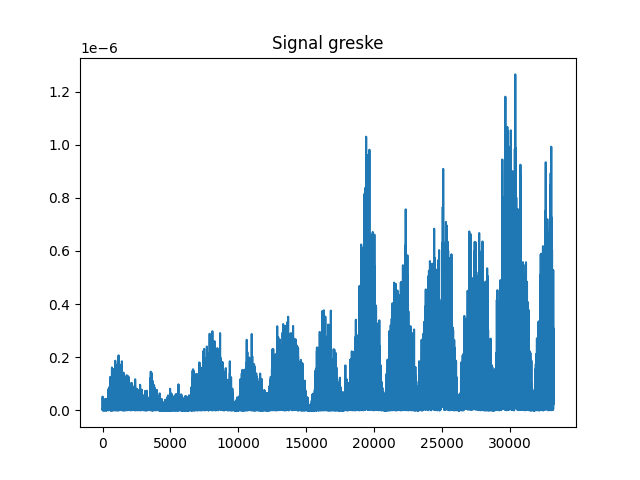

In [22]:
signal_error(tremolo_output,tremolo_from_C)

Flanger 

![](basic_flanger_without_feedback.png)

In [ ]:
def flanger(input_signal, Fs, Flfo, delay_ms, gain):
    """
    Primjena flanger efekta na ulazni audio signal

    Ulazni parametri:
    input_signal -   ulazni audio signal
    Fs           -   frekvencija odmjeravanja (Hz)
    Flfo         -   frekvencija oscilatora (~1Hz)                
    delay_ms     -   maksimalno željeno kašnjenje u milisekundama(0-15ms)
    gain         -   pojačanje, od 0 do 1     
    
    Return:      
    Audio signal sa primijenjenim flanger efektom
    """

    #maksimalno kasnjenje u broju odmjeraka
    N = (delay_ms / 1000) * Fs

    output_signal = np.zeros(len(input_signal))

    for i in range(len(input_signal)):
        d = int((N / 2) * (1 + np.sin(2 * np.pi * i *(Flfo/ Fs))))
        if d <= N:
            output_signal[i] = input_signal[i] + (gain * input_signal[(i - d)])
        else:
            output_signal[i] = input_signal[i]

    output_signal = output_signal/np.max(np.abs(output_signal))
    return output_signal

In [ ]:
flanger_output = flanger(input,Fs,0.9,3.0,0.4)
plotSignals(input,flanger_output)
Audio(flanger_output,rate=Fs)

In [ ]:
def flanger_buffer(input_signal, Fs, Flfo, delay_ms, gain):
    """
    Primjena flanger efekta na ulazni audio signal koristeći kružni bafer za kašnjenje.

    Ulazni parametri:
    input_signal    - Ulazni audio signal.
    Fs              - Frekvencija odmjeravanja (Hz).
    Flfo            - Frekvencija oscilatora (Hz).
    delay_ms        - Maksimalno željeno kašnjenje u milisekundama (0-15ms).
    gain            - Pojačanje, od 0 do 1.

    Returns:
    Audio signal sa primijenjenim flanger efektom.
    """
    # Maksimalno kašnjenje u broju uzoraka
    max_delay_samples = int((delay_ms / 1000) * Fs)
    delay_buffer = np.zeros(max_delay_samples)  # Kružni bafer
    write_pointer = 0  # Pokazivač za upis

    output_signal = np.zeros(len(input_signal))

    for i in range(len(input_signal)):
        # Modulacija kašnjenja pomoću LFO
        delay_samples = int((max_delay_samples / 2) * (1 + np.sin(2 * np.pi * i * (Flfo / Fs))))

        # Izračunavanje pozicije za čitanje iz kružnog bafera
        read_pointer = (write_pointer - delay_samples + max_delay_samples) % max_delay_samples

        # Čitanje uzorka iz kružnog bafera
        delayed_sample = delay_buffer[read_pointer]

        # Dodavanje efektiranog uzorka na ulazni signal
        output_signal[i] = input_signal[i] + (gain * delayed_sample)

        # Ažuriranje kružnog bafera
        delay_buffer[write_pointer] = input_signal[i]
        write_pointer = (write_pointer + 1) % max_delay_samples

    # Normalizacija izlaznog signala može biti opcionalna zavisno od željenog izlaznog nivoa
    output_signal = output_signal / np.max(np.abs(output_signal))
    return output_signal


In [ ]:
flanger_buff = flanger_buffer(input,Fs,1,10,0.5)
plotSignals(input,flanger_buff)
Audio(flanger_buff,rate=Fs)

WahWah

In [ ]:
def compute_biquad_coefficients(fs, f0, Q):
    """
    Izračunava koeficijente za BiQuad band-pass filter.
    
    Ulazni parametri:
        fs (float): Frekvencija uzorkovanja u Hz.
        f0 (float): Centralna frekvencija filtra u Hz.
        Q (float): Faktor kvaliteta filtra.
    
    Returns:
        (b0, b1, b2, a0, a1, a2): Koeficijenti filtra.
    """
    w0 = 2 * np.pi * f0 / fs
    alpha = np.sin(w0) / (2 * Q)

    b0 = alpha
    b1 = 0.0
    b2 = -alpha
    a0 = 1 + alpha
    a1 = -2 * np.cos(w0)
    a2 = 1 - alpha

    return b0, b1, b2, a0, a1, a2

def wahwah_effect(input_signal, fs, f_min, f_max, Q, lfo_rate):
    """
    Primjenjuje wah-wah efekat na ulazni signal koristeći BiQuad filter.
    
    Ulazni parametri:
        input_signal - Ulazni audio signal.
        fs - Frekvencija uzorkovanja u Hz.
        f_min - Minimalna centralna frekvencija filtra.
        f_max - Maksimalna centralna frekvencija filtra.
        Q - Faktor kvaliteta filtra.
        lfo_rate - Brzina LFO-a u Hz.
    
    Returns:
        Audio signal sa primenjenim wah-wah efektom.
    """
    output_signal = np.zeros(len(input_signal))
    lfo = np.sin(2 * np.pi * np.arange(len(input_signal)) * lfo_rate / fs)
    f0 = f_min + (f_max - f_min) * (lfo + 1) / 2

    for i in range(len(input_signal)):
        b0, b1, b2, a0, a1, a2 = compute_biquad_coefficients(fs, f0[i], Q)
        if i >= 2:
            output_signal[i] = (b0/a0)*input_signal[i] + (b1/a0)*input_signal[i-1] + (b2/a0)*input_signal[i-2] - (a1/a0)*output_signal[i-1] - (a2/a0)*output_signal[i-2]
    output_signal = output_signal/np.max(np.abs(output_signal))

    return output_signal


In [ ]:
wah_wah_output = wahwah_effect(input,Fs,500, 3000,2.5,1)
plotSignals(input,wah_wah_output)
Audio(wah_wah_output,rate=Fs)

Reverb

In [ ]:
def fconv(x,h):
    ly = len(x)+len(h) -1
   
    X = fft(x, ly)
    H = fft(h, ly)
    
    Y = X * H  # convolution
    y = np.real(ifft(Y,ly))
    y=y/np.max(np.abs(y))
    return y


impulse_response_file = "impulse_cathedral.wav"
s, h1 = wavfile.read(impulse_response_file)

h1 = h1/np.max(np.abs(h1))

y = fconv(input,h1)


Audio(y,rate=Fs)

